In [2]:
import numpy as np
import os
import os.path
import cv2
import matplotlib.pyplot as plt
from skimage.transform import rotate
from skimage.feature import hog
from skimage.exposure import rescale_intensity

import pandas as pd


In [3]:
dir = './Dataset'

In [4]:
# создадим датафрем с нашими данными.

name = []
for dirname, _, filenames in os.walk(dir):
    for filename in filenames:
      name.append([dirname.split('/')[-1], os.path.join(dirname, filename)])

df = pd.DataFrame(columns = ['category', 'way'], data = name)
df.shape

(256, 2)

In [5]:
# заменим категриальные признаки на числовые
slovar = {}
my_list = df['category'].unique()
for counter, value in enumerate(my_list):
  slovar[value] = counter

df['category'] = df['category'].map(slovar)

In [6]:
df.head()

,category,way
0,0,./Dataset/fork/IMG_20211118_154738_1.jpg
1,0,./Dataset/fork/IMG_20211119_084920_0.jpg
2,0,./Dataset/fork/IMG_20211118_154748_0.jpg
3,0,./Dataset/fork/IMG_20211120_173901_1.jpg
4,0,./Dataset/fork/IMG_20211120_173901_2.jpg


Затем применим фильтр Гаусса для сглаживания, и уменьшим его

In [7]:
def first_prepare(img):
    # размытие (сглаживание)
    img = cv2.GaussianBlur(img, (15, 15), 3)

    # уменьшим размер
    img = cv2.resize(img, (64, 64))

    # нормализуем интенсивности от 0 до 255
    img = cv2.normalize(img, None, 0, 255, norm_type=cv2.NORM_MINMAX)
    
    return img

# img = first_prepare(img)
# plt.imshow(img, cmap="gray")

## Bag of words для исходной картинки (несегментированной)

In [8]:
def get_frames(image, image_name):
    # картинка 64*64
    win_size = (64, 64)
    block_size = (16, 16)
    block_stride = (8, 8)
    cell_size = (16, 16)
    n_bins = 9

    hog = cv2.HOGDescriptor(win_size, block_size, block_stride, cell_size, n_bins)

    winStride = (8, 8)
    padding = (0, 0) 
    hist = hog.compute(image, winStride, padding) 

    # количество ячеек 7 * 7, по 9 бинов в каждом = 441
    # сделаем resize в матрицу 49*9, чтобы каждая ячейка (слово) описывалась отдельно
    
    data = np.reshape(hist, (49, 9))
    df = pd.DataFrame(data)
    df["row"] = df.index % 7
    df["col"] = df.index // 7
    df["name"] = image_name
    
    return df[["name", "row", "col", 0, 1, 2, 3, 4, 5, 6, 7, 8]]

In [9]:
#get_frames(img, "some name")

In [10]:
def all_frames(file_list):
    frames = None
    
    for f in file_list:
        image = cv2.imread(f, cv2.IMREAD_GRAYSCALE)
        image = first_prepare(image)
        if frames is None:
            frames = get_frames(image, f)
            
        else:
            frames = pd.concat([frames, get_frames(image, f)], axis=0)
    
    frames.reset_index(drop=True, inplace=True)
    
    return frames

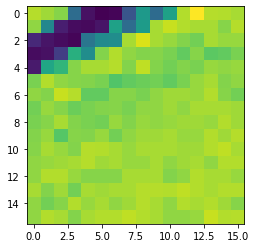

In [12]:
def show_frame(name, row, col):
    image = cv2.imread(name, cv2.IMREAD_GRAYSCALE)
    image = first_prepare(image)
    frame = image[row * 8 : (row + 2) * 8, col * 8 : (col + 2) * 8]
    return frame

plt.imshow(show_frame("./Dataset/fork/IMG_20211119_084920_0.jpg", 4, 2))

In [13]:
from sklearn.cluster import KMeans

file_list = df["way"].to_list()

cls = KMeans(n_clusters=25)
all_frames_data = all_frames(file_list)
X = all_frames_data[[0, 1, 2, 3, 4, 5, 6, 7, 8]]

cls.fit(X)
all_frames_data["cluster"] = cls.predict(X)

all_frames_data.to_csv("clusters.csv")

In [14]:
all_frames_data["cluster"].value_counts()

3     4294
20     805
16     687
1      648
17     630
21     619
15     572
8      405
11     360
6      356
19     334
10     288
0      282
4      264
22     254
5      247
12     244
14     206
23     204
9      184
13     157
2      155
7      151
24     119
18      79
Name: cluster, dtype: int64

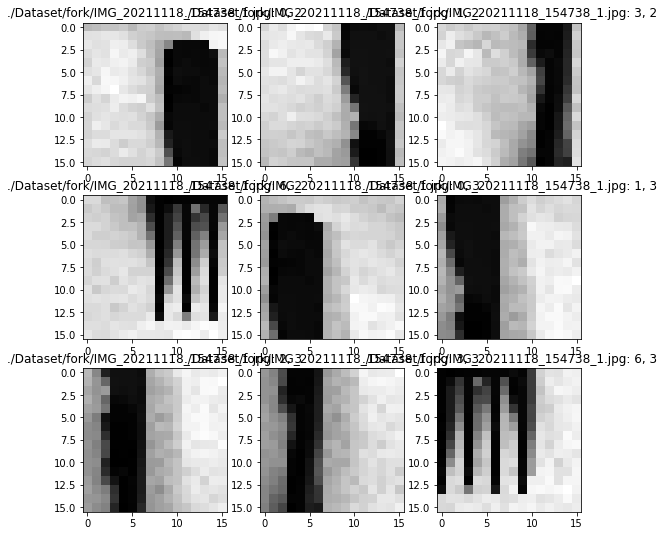

In [15]:
cluster = 7
sample = all_frames_data[all_frames_data["cluster"] == cluster][:9]
sample.reset_index(drop=True, inplace=True)

fig = plt.figure(figsize=(9, 9))

for i in range(9):
    name = sample.loc[i, "name"]
    row = sample.loc[i, "row"]
    col = sample.loc[i, "col"]

    plt.subplot(3, 3, i + 1)
    plt.imshow(show_frame(name, row, col), cmap='gray')
    plt.title(f"{name}: {row}, {col}")
    

## Bag of words для сегментированной картинки